In [1]:
# --- Standard Library ---
import os
import sys
import random
import yaml

# --- Third-Party Libraries ---
import numpy as np
import torch
from tqdm import tqdm
from matplotlib import pyplot as plt
from termcolor import colored
from accelerate import Accelerator
from scipy.ndimage import (
    binary_closing,
    binary_opening,
    binary_dilation,
    binary_erosion,
    generate_binary_structure
)

# --- Local Imports ---
sys.path.append("..")
sys.path.append("SegFormer3D-main")

from dataloaders.build_dataset import build_dataset, build_dataloader
from architectures.build_architecture import build_architecture
from metrics.competition_metric import ULS23_evaluator


c:\Users\Lazar\anaconda3\envs\aimi\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import os
import torch
import nibabel
import numpy as np
from tqdm import tqdm
from joblib import Parallel, delayed
import matplotlib.pyplot as plt
from matplotlib import animation
from monai.data import MetaTensor
from multiprocessing import Process, Pool
from sklearn.preprocessing import MinMaxScaler 
from monai.transforms import (
    Orientation,
    EnsureType,
)
import SimpleITK as sitk
# whoever wrote this code knew what he was doing (hint: It was me!)

"""
data 
 │
 ├───train
 │      ├──imageTr
 │      │      └──BRATS_001_0000.nii.gz
 │      │      └──BRATS_001_0001.nii.gz
 │      │      └──BRATS_001_0002.nii.gz
 │      │      └──BRATS_001_0003.nii.gz
 │      │      └──BRATS_002_0000.nii.gz
 │      │      └──...
 │      ├──labelsTr
 │      │      └──BRATS_001.nii.gz
 │      │      └──BRATS_002.nii.gz
 │      │      └──...
 │      ├──imageTs
 │      │      └──BRATS_485_000.nii.gz
 │      │      └──BRATS_485_001.nii.gz
 │      │      └──BRATS_485_002.nii.gz
 │      │      └──BRATS_485_003.nii.gz
 │      │      └──BRATS_486_000.nii.gz
 │      │      └──...

"""
class ConvertToMultiChannelBasedOnUls2023Classes(object):
    """
    Convert labels to multi channels based on brats17 classes:
    "0": "background", 
    "1": "edema",
    "2": "non-enhancing tumor",
    "3": "enhancing tumour"
    Annotations comprise the GD-enhancing tumor (ET — label 4), the peritumoral edema (ED — label 2),
    and the necrotic and non-enhancing tumor (NCR/NET — label 1)
    """
    def __call__(self, img):

        # if img has channel dim, squeeze it
        if img.ndim == 4 and img.shape[-1] == 1:
            img = img.squeeze(-1)

        # We have two classes: 0 (background) and 1 (lesion)
        result = [
            img == 0,  # background
            img == 1   # lesion
        ]
        # merge background and lesion
        return torch.stack(result, dim=0) if isinstance(img, torch.Tensor) else np.stack(result, axis=0)

class ULS2023Preprocess:
    def __init__(
        self,
        root_dir: str,
        train_folder_name: str = "train",
        save_dir: str = "../ULS2023_Training_Data",
        cpu_count: int = 1,
    ):
        """
        root_dir: path to the data folder where the raw train folder is
        roi: spatiotemporal size of the 3D volume to be resized
        train_folder_name: name of the folder of the training data
        save_dir: path to directory where each case is going to be saved as a single file containing four modalities
        """

        # self.train_folder_dir = os.path.join(root_dir, train_folder_name)
        # print(f"train folder dir: {self.train_folder_dir}")
        # label_folder_dir = os.path.join(root_dir, train_folder_name, "labelsTr")
        # assert os.path.exists(self.train_folder_dir)
        # assert os.path.exists(label_folder_dir)
        
        # self.save_dir = save_dir
        # # we only care about case names for which we have label! 
        # self.case_name = next(os.walk(label_folder_dir), (None, None, []))[2]
        # print(f"Number of cases: {len(self.case_name)}")
        # self.cpu_count = cpu_count

        # if not os.path.exists(self.save_dir):
        #     os.makedirs(self.save_dir)

    def __len__(self):
        return self.case_name.__len__()

    def normalize(self, x:np.ndarray)->np.ndarray:
        # Transform features by scaling each feature to a given range.
        scaler = MinMaxScaler(feature_range=(0, 1))
        # (H, W, D) -> (H * W, D)
        normalized_1D_array = scaler.fit_transform(x.reshape(-1, x.shape[-1]))
        normalized_data = normalized_1D_array.reshape(x.shape)
        return normalized_data

    def orient(self, x: MetaTensor) -> MetaTensor:
        # orient the array to be in (Right, Anterior, Superior) scanner coordinate systems
        assert type(x) == MetaTensor
        return Orientation(axcodes="RAS")(x)

    def detach_meta(self, x: MetaTensor) -> np.ndarray:
        assert type(x) == MetaTensor
        return EnsureType(data_type="numpy", track_meta=False)(x)

    def crop_brats2021_zero_pixels(self, x: np.ndarray)->np.ndarray:
        # get rid of the zero pixels around mri scan and cut it so that the region is useful
        # crop (240, 240, 155) to (128, 128, 128)
        return x[:, 56:184, 56:184, 13:141]

    def remove_case_name_artifact(self, case_name: str)->str:
        # BRATS_066.nii.gz -> BRATS_066
        return case_name.rsplit(".")[0]

    def get_fp(self, case_name: str, folder: str, mri_code: str = None):
        """
        return the modality file path
        case_name: patient ID
        folder: either [imagesTr, labelsTr]
        mri_code: code of any of the ["Flair", "T1w", "T1gd", "T2w"]
        """
        if mri_code:
            f_name = f"{case_name}_{mri_code}.nii.gz"
        else:
            f_name = f"{case_name}.nii.gz"

        modality_fp = os.path.join(
            self.train_folder_dir,
            folder,
            f_name,
        )
        return modality_fp

    def load_nifti(self, fp):
        """
        load a nifti file
        fp: path to the nifti file with (nii or nii.gz) extension
        """
        nifti_data = nibabel.load(fp)
        # get the floating point array
        nifti_scan = nifti_data.get_fdata()
        # get affine matrix
        affine = nifti_data.affine
        return nifti_scan, affine

    def _2metaTensor(self, nifti_data: np.ndarray, affine_mat: np.ndarray):
        """
        convert a nifti data to meta tensor
        nifti_data: floating point array of the raw nifti object
        affine_mat: affine matrix to be appended to the meta tensor for later application such as transformation
        """
        # creating a meta tensor in which affine matrix is stored for later uses(i.e. transformation)
        scan = MetaTensor(x=nifti_data, affine=affine_mat)
        # adding a new axis
        D, H, W = scan.shape
        # adding new axis
        scan = scan.view(1, D, H, W)
        return scan

    def preprocess_uls(self, data_fp: str, is_label: bool = False)->np.ndarray:
        """
        apply preprocess stage to the modality
        data_fp: directory to the modality
        """
        data, affine = self.load_nifti(data_fp)

        # First orient data, because adding new dimensions before makes affine and data incompatible 
        data = MetaTensor(x=data, affine=affine)
        # for oreinting the coordinate system we need the affine matrix
        data = self.orient(data)
        # detaching the meta values from the oriented array
        data = self.detach_meta(data)

        # label do not the be normalized 
        if is_label:
            # Binary mask does not need to be float64! For saving storage purposes!
            data = data.astype(np.uint8)
            # categorical -> one-hot-encoded 
            # (128, 128, 64, 1) -> (2, 128, 128, 64)
            data = ConvertToMultiChannelBasedOnUls2023Classes()(data)
            # print("Label shape after channel mapping: ", data.shape)
        else:
            data = self.normalize(x=data)
            # (128, 128, 64, 1) -> (1, 128, 128, 64)
            data = np.moveaxis(data, -1, 0)

        # images have already been cropped
        #data = self.crop_brats2021_zero_pixels(data)

        return data

    def __getitem__(self, idx):
        # Example: MIX_00001_0000.nii.gz
        case_name = self.case_name[idx]
        # Remove case name file extension: Example: MIX_00001_0000
        case_name = self.remove_case_name_artifact(case_name)
        
        case_path = self.get_fp(case_name, "imagesTr", mri_code='0000')
        
        # preprocess image
        im = self.preprocess_uls(case_path, is_label=False)
        # print("Preprocessed image shape: ", im.shape)
        im_transv = im.swapaxes(1, 3) # transverse plane
        # print("Preprocessed image shape after swapaxes: ", im_transv.shape)

        # preprocess segmentation label
        label = self.get_fp(case_name, "labelsTr")
        label = self.preprocess_uls(label, is_label=True)
        # print("Preprocessed label shape: ", label.shape)
        label = label.swapaxes(1, 3) # transverse plane 
        # print("Preprocessed label shape after swapaxes: ", label.shape)

        # add channel dimension (1, D, H, W)
        # im = im_transv.unsqueeze(0)
    
        return im_transv, label, case_name


    def __call__(self):
        print("started preprocessing ULS2023...")
        with Pool(processes=self.cpu_count) as multi_p:
            result = multi_p.map_async(func=self.process, iterable=range(self.__len__()))
            multi_p.close()
            multi_p.join()
            result.get()

        print("finished preprocessing ULS2023...")

    def process(self, idx):
        tensor, label, case_name = self.__getitem__(idx)
        # creating the folder for the current case id
        data_save_path = os.path.join(self.save_dir, case_name)
        if not os.path.exists(data_save_path):
            os.makedirs(data_save_path)
        tensor_fn = data_save_path + f"/{case_name}_im.pt"
        label_fn = data_save_path + f"/{case_name}_label.pt"
        torch.save(tensor, tensor_fn)
        torch.save(label, label_fn)


In [3]:
# test_data_path = "/d/hpc/home/jf73497/projects/aimi-project-data/raw/Dataset001_MIX"

image_path = "./MIX_06966_0000.nii.gz"
label_path = "./MIX_06966.nii.gz"

# Read image slice (single slice)
image_itk = sitk.ReadImage(image_path)
image_raw = sitk.GetArrayFromImage(image_itk).astype(np.float32)
# Read full label volume
label_itk = sitk.ReadImage(label_path)
label = sitk.GetArrayFromImage(label_itk).astype(np.int64)

pre = ULS2023Preprocess(".")

image = pre.preprocess_uls(image_path, False).swapaxes(1, 3)
label = pre.preprocess_uls(label_path, True).swapaxes(1, 3)


In [32]:
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

def visualize_middle_slice_with_border(voi, prediction, label, pred_os):
    """
    Visualize the middle slice of a VOI with border-only overlays for prediction and label.

    Args:
        voi (torch.Tensor): Input VOI of shape (1, 1, 64, 128, 128)
        prediction (torch.Tensor): Binary prediction of the same shape
        label (torch.Tensor): Binary ground truth label of the same shape
    """
    assert voi.shape == prediction.shape == label.shape, "Shapes must match and be (1, 1, 64, 128, 128)"

    # Convert tensors to NumPy arrays
    voi_np = voi.squeeze()
    pred_np = prediction.squeeze().astype(np.uint8)
    label_np = label.squeeze().astype(np.uint8)
    pred_os = pred_os.squeeze().astype(np.uint8)

    # Get the middle slice along the depth dimension
    mid_slice = voi_np.shape[0] // 2
    base_slice = voi_np[mid_slice]
    pred_slice = pred_np[mid_slice]
    label_slice = label_np[mid_slice]
    pred_os = pred_os[mid_slice]

    # Define edge detection kernel (simple Laplacian)
    kernel = np.array([[1, 1, 1],
                       [1, -8, 1],
                       [1, 1, 1]], dtype=np.int8)

    def extract_border(binary_slice):
        padded = np.pad(binary_slice, pad_width=1, mode='constant', constant_values=0)
        border = np.zeros_like(binary_slice)
        for i in range(binary_slice.shape[0]):
            for j in range(binary_slice.shape[1]):
                region = padded[i:i+3, j:j+3]
                val = np.sum(region * kernel)
                border[i, j] = 1 if val != 0 and binary_slice[i, j] == 1 else 0
        return border

    # Extract borders
    pred_border = extract_border(pred_slice)
    label_border = extract_border(label_slice)
    pred_os = extract_border(pred_os)

    # Plotting
    plt.figure(figsize=(8, 8))
    plt.imshow(base_slice, cmap="gray")

    # Overlay label border (red)
    y_label, x_label = np.where(label_border == 1)
    plt.scatter(x_label, y_label, c='#FF3F33', s=2, label='Label Border')

    # Overlay prediction border (blue)
    y_pred, x_pred = np.where(pred_border == 1)
    plt.scatter(x_pred, y_pred, c='#3D3BF3', s=2, label='Prediction Border')

    # Overlay prediction border (blue)
    y_pred, x_pred = np.where(pred_os == 1)
    plt.scatter(x_pred, y_pred, c='#FF9B17', s=2, label='OS Prediction Border')

    # Legend and formatting
    legend_elements = [
        Patch(facecolor='none', edgecolor='#FF3F33', label='Label Border'),
        Patch(facecolor='none', edgecolor='#3D3BF3', label='SegFormer3D Prediction Border'),
        Patch(facecolor='none', edgecolor='#FF9B17', label='SegFormer3D_OS Prediction Border'),
    ]
    plt.legend(handles=legend_elements, loc='lower right')
    plt.title("SegFormer3D Middle Z Slice Predictions")
    plt.axis("off")
    plt.tight_layout()
    plt.show()


In [5]:


evaluator = ULS23_evaluator()

def load_config(config_path: str):
    """loads the yaml config file

    Args:
        config_path (str): _description_

    Returns:
        Dict: _description_
    """
    with open(config_path, "r") as file:
        config = yaml.safe_load(file)
    return config

##################################################################################################
def seed_everything(config) -> None:
    seed = config["training_parameters"]["seed"]
    os.environ["PYTHONHASHSEED"] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False


def load_checkpoint(
        config,
        accelerator,
):
    accelerator.load_state(
        config["training_parameters"]["load_checkpoint"]["load_checkpoint_path"]
    )
   
def _run_eval(model, image) -> None:
    """_summary_"""
    # Tell wandb to watch the model and optimizer values

    model.eval()

    with torch.no_grad():

        logits = model.forward(image)
        logits = logits[:, 1:, ...]
        predicted = torch.sigmoid(logits)

    return predicted



In [6]:
print(image.shape)

model_input_image = torch.from_numpy(image).unsqueeze(0).to('cuda').float()

model_input_image_raw = torch.from_numpy(image_raw).unsqueeze(0).unsqueeze(0).to('cuda').float()

(1, 64, 128, 128)


In [12]:
# load config
config = load_config(r'./config.yaml')

# set seed
seed_everything(config)

# build the Model
model = build_architecture(config)


# use accelarate
accelerator = Accelerator(
    log_with="wandb",
    gradient_accumulation_steps=config["training_parameters"][
        "grad_accumulate_steps"
    ],
)
accelerator.init_trackers(
    project_name=config["project"],
    config=config,
    init_kwargs={"wandb": config["wandb_parameters"]},
)


# convert all components to accelerate
model = accelerator.prepare_model(model=model)

if config["training_parameters"]["load_checkpoint"]["load_full_checkpoint"]:
        print("[info] -- Loading checkpoint.")
        load_checkpoint(
            config=config,
            accelerator=accelerator,)

print("[info] -- Running evaluation only.")
prediction = ULS_per_threshold = _run_eval(model, model_input_image)

prediction_raw = ULS_per_threshold = _run_eval(model, model_input_image_raw)

Error in callback <bound method _WandbInit._resume_backend of <wandb.sdk.wandb_init._WandbInit object at 0x000001F0F39E0AC0>> (for pre_run_cell), with arguments args (<ExecutionInfo object at 1f0f39e3bb0, raw_cell="# load config
config = load_config(r'./config.yaml.." store_history=True silent=False shell_futures=True cell_id=vscode-notebook-cell:/c%3A/Users/Lazar/OneDrive/Desktop/RU%20Courses/AI%20in%20Medical%20Imaging/project/aimi-project/SegFormer3D-main/tta_aug/prediction_label_viz.ipynb#W6sZmlsZQ%3D%3D>,),kwargs {}:


TypeError: _WandbInit._resume_backend() takes 1 positional argument but 2 were given

[info] -- Loading checkpoint.
[info] -- Running evaluation only.


c:\Users\Lazar\anaconda3\envs\aimi\lib\site-packages\accelerate\checkpointing.py:159: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  models[i].load_state_dict(torch.load(inpu

In [13]:
prediction_mask = prediction > 0.5

prediction_mask_raw = prediction_raw > 0.5
print(prediction_mask.shape)

torch.Size([1, 1, 64, 128, 128])


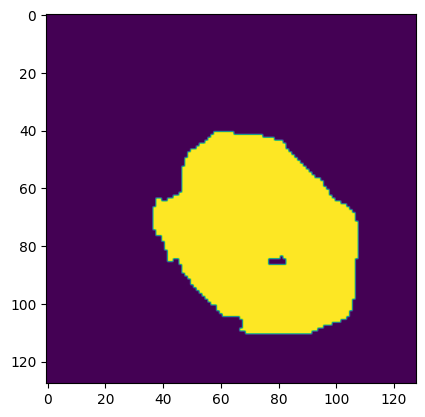

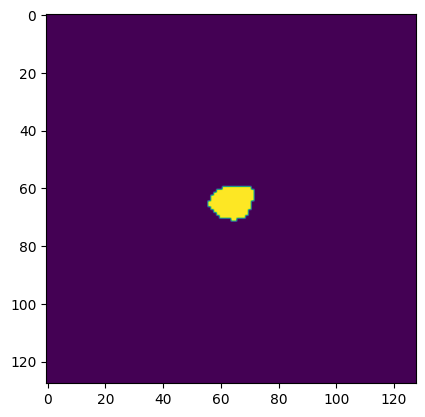

In [14]:
plt.imshow(prediction_mask[0, 0, 32].cpu())
plt.show()
plt.imshow(prediction_mask_raw[0, 0, 32].cpu())
plt.show()


In [37]:
pred_os = torch.save(prediction_mask, 'pred_non_os.pt',)

(1, 64, 128, 128) torch.Size([1, 1, 64, 128, 128]) (2, 64, 128, 128)
(64, 128, 128) (64, 128, 128) (64, 128, 128)


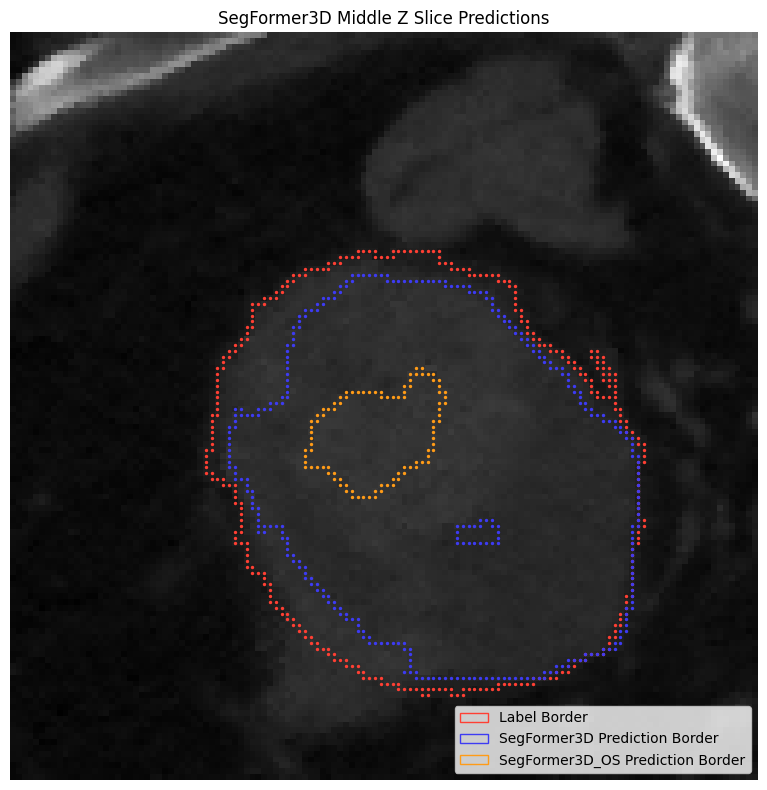

In [33]:
print(image.shape, prediction_mask.shape, label.shape)


image_viz = image.squeeze()
preD_viz = prediction_mask.squeeze().cpu().numpy()
preD_viz_raw = prediction_mask_raw.squeeze().cpu().numpy()
pred_os_viz = pred_os.squeeze().cpu().numpy()
label_viz = label[1:, ...].squeeze()
print(image_viz.shape, preD_viz.shape, label_viz.shape)
visualize_middle_slice_with_border(image_viz, preD_viz, label_viz, pred_os_viz)